# ECON 570: Assignment 2

Masashi Yoshioka (ID: 3200-3439-52)

April 15, 2022

I will discuss all the four settings below.

You can find the data generated for this assignment in the "data" folder. Note that I do not include the variables generated in each iteration of a Monte Carlo simulation because it would generate huge but useless data.

You can find the functions that I have defined for this assignment in the "utils" folder.

In [1]:
##############################################################
### Please comment out or use your own path before running ###
##############################################################
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
##############################################################

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import graphviz as gr
import random

# Helper functions from functions.py
from utils.functions import my_DGP, fn_experiment, fn_plot_with_ci, fn_monte_carlo

# Set random seeds
np.random.seed(570)
random.seed(570)

# Define default colors
plt.style.use('./style/usc_color')

## 1. Random Assignment

Each section is organized as follows henceforth. In subsection 1, I describe a data generating process (DGP) and show histograms. In subsection 2, I illustrate the DGP using a directed acyclic graph (DAG). In subsection 3, I implement a Monte Carlo simulation for each of two cases and see how the estimator performs in different regression models. In subsection 4, I give an example of a real-life situation that appears to be consistent with the DGP.

### 1.1 DGP Simulation

I assume the following DGP in this section:

$$
Y = \alpha + \tau T + \mathbf{X} \beta + e,
$$

where

- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect, i.e., $Y_1 - Y_0 = \tau$ for any observations where $Y_1$ and $Y_0$ are potential outcomes,
- $T$ (treatment) is an $N \times 1$ matrix whose element is randomly assigned to 1 with proportion $p \equiv 0.5$ or 0 with $1 - p \equiv 0.5$,
- $\mathbf{X}$ (covariates) is an $N \times 10$ matrix (i.e., there are 10 covariates) whose row follows a multivariate normal distribution that has a within-correlation of 0.5,
- $\beta$ (coefficients on covariates) is a $10 \times 1$ matrix whose element follows *i.i.d.* $N(1, 1)$, and
- $e$ (disturbance) is an $N \times 1$ matrix whose element follows *i.i.d.* $N(0, 1)$.

Since $T$ is randomly assigned, we can assume $Y_0, Y_1 \perp T$, which is the main assumption for random assignment.

First, I generate one set of variables and plot histograms. I first assume the sample size of $N = 1000$.

In [4]:
# Generate data
# You can find the data in '1_1_Random_Assignment.csv'
tau = 2; nobs = 1000

dgp1 = my_DGP(nobs)
Y, T, X, _, _, _ = dgp1.generate(tau, output = True, file_name = '1_1_Random_Assignment.csv')

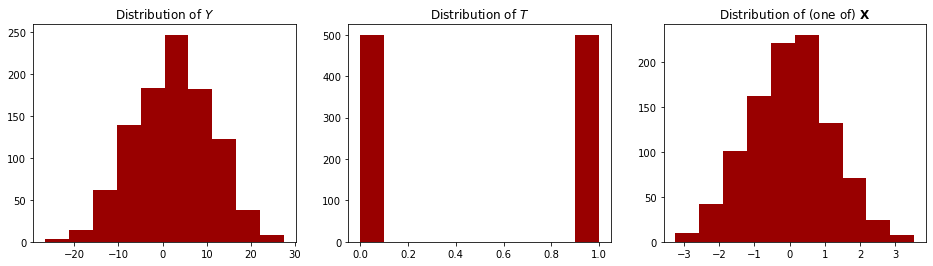

In [5]:
# Plot distributions of data
fig, axes = plt.subplots(1, 3, figsize = (16, 4))

axes[0].hist(Y)
axes[0].set_title('Distribution of $Y$', fontdict = {'fontsize': 12})

axes[1].hist(T)
axes[1].set_title('Distribution of $T$', fontdict = {'fontsize': 12})

axes[2].hist(X[:, 0])
axes[2].set_title('Distribution of (one of) $\mathbf{X}$', fontdict = {'fontsize': 12})

plt.show()

We can see that $X$ shows a bell-shape by design. By assumption, a half of $T$ is assiged to treatment (1) and the other is to control (0). $Y$ also shows a bell-shape.

Next, I see the correlations between variables using Monte Carlo simulations. That is, I generate data 2,000 times and plot the histograms of correlation coefficients obtained for each iteration.

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 171.72it/s]


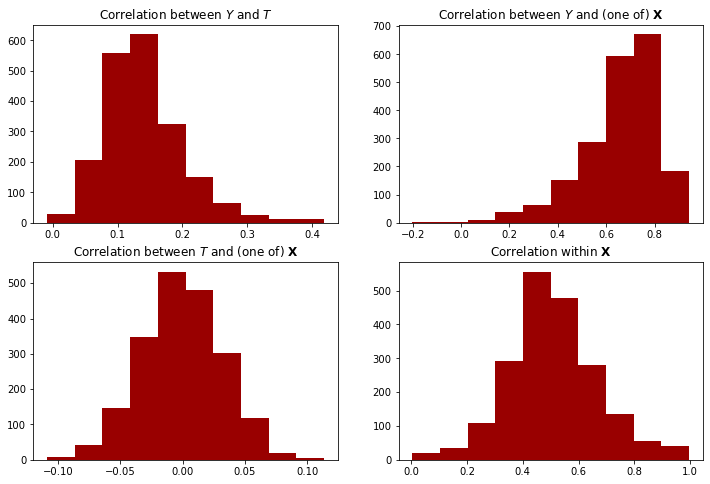

In [6]:
# Plot correlations between variables
# Generate data and calculate correlations 2,000 times
# You can find the data of correlations in '1_2_Correlations_RA.csv'
dgp1.plot_corr(tau)

By design, "$Y$ and $T$" and "$\mathbf{X}$ and $Y$" are positively correlated on average. On the other hand, $T$ and $\mathbf{X}$ appear to be uncorrelated, which is required for random assignment. We can also see that the correlation within $\mathbf{X}$ is around 0.5 on average.

### 1.2 DAG Illustration

This DGP can be illustrated by the following DAG:

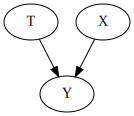

In [7]:
# Create the DAG
g1 = gr.Digraph()
g1.edge('T', 'Y')
g1.edge('X', 'Y')

g1

### 1.3 Monte Carlo Simulation

In this subsection, before running Monte Carlo simulations, I plot the average treatment effect (ATE) estimates $\hat{\tau}$ and 95% confidence intervals for $\tau$ assuming different sample sizes of $N \in \{20, 22, \ldots, 1000\}$ to show graphically how well each estimator performs.

#### a. Not controlling for any covariates

First, I get the ATE estimate $\hat{\tau}$ by OLS assuming the following model:

$$
Y = \alpha + \tau T + e.
$$

Note that the OLS estimator $\hat{\tau}$ equals the difference in average outcomes between treated and controlled samples. Since $T$ is randomly assigned, we should be able to get an unbiased estimator for $\tau$, while its standard error can be large because covariates $\mathbf{X}$ are not controlled.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 348.27it/s]


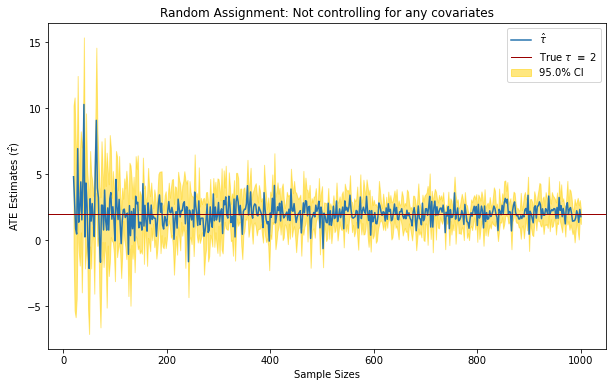

In [8]:
# Plot the ATE estimates and confidence intervals
# The ATE is estimated by linear regression with only T
# You can find the data for CI in '1_3a_CI_RA_without_Covars.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, output = True,
                                                  file_name = '1_3a_CI_RA_without_Covars.csv')

# Plot the results
caption = 'Random Assignment: Not controlling for any covariates'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

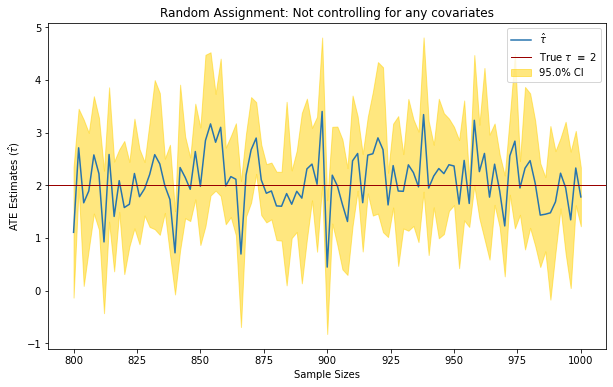

In [9]:
# Show the last part to make it easier to see
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

As we can see, $\hat{\tau}$ is fluctuating around $\tau \equiv 2$, which is consistent with the theory. As sample size gets larger, the value of $\hat{\tau}$ appears to converge to the true value of $\tau$.  

Now I run Monte Carlo simulations with sample sizes of $N = 100$ and $N = 1000$, and compute a bias, RMSE and size. The bias and the RMSE are defined as

$$
\mathrm{bias} \equiv \frac{1}{R} \sum_{r = 1}^{R} (\hat{\tau}_r - \tau),\\
\mathrm{RMSE} \equiv \sqrt{\frac{1}{R} \sum_{r = 1}^{R} (\hat{\tau}_r - \tau)^2},\\
$$

respectively, where $\hat{\tau}_r$ is the estimate for $\tau$ obtained in the $r$-th iteration. The size of a statistical test is defined as the probability of rejecting the null hypothesis when it is actually true. In this assignment, I will implement the two-sided *t*-test using the *t*-statistic

$$
t = \frac{\hat{\tau}_r - \tau}{\mathrm{se}(\hat{\tau}_r)},
$$

and reject the null hypothesis $H_0: \tau = 2$ if $t$ under $H_0$, i.e., $t = (\hat{\tau}_r - 2)/{\mathrm{se}(\hat{\tau}_r)}$, falls into the rejection region $\{ t \ | t \notin [t_{0.025}, t_{0.975}] \}$ where $t_{\alpha}$ is a $100\alpha$-percentile of a *t*-distribution with appropriate degrees of freedom. If $\hat{\tau}_r$ is a consistent estimator for $\tau$, the size should theoretically converge to 5% as sample size increases.

I use $R = 2000$ as a number of iterations henceforth.

In [10]:
# Monte Carlo simulations without controlling for X
# You can find the data of tauhats in '1_4a_MC_RA_without_Covars.csv'
fn_monte_carlo(tau, X_control = False, output = True, file_name = '1_4a_MC_RA_without_Covars.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 172.95it/s]


N = 100: bias = -0.003228, RMSE = 1.678907, size = 0.0550
N = 1000: bias = 0.009831, RMSE = 0.513823, size = 0.0460


We can see that the RMSE gets smaller as the sample size gets larger. The size is quite close to the theoretical value 5%.

#### b. Controlling for all the covariates that affect the outcome

Next, I compute the ATE estimate $\hat{\tau}$ by OLS assuming the following model:

$$
Y = \alpha + \tau T + \mathbf{X} \beta + e,
$$

which is exactly the same as the assumed DGP. The theory suggests that controlling for $\mathbf{X}$ should allow $\mathbf{X}$ to explain some of the variance of $Y$ and help reduce the standard error of $\hat{\tau}$, even if $T$ and $\mathbf{X}$ are independent.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 349.96it/s]


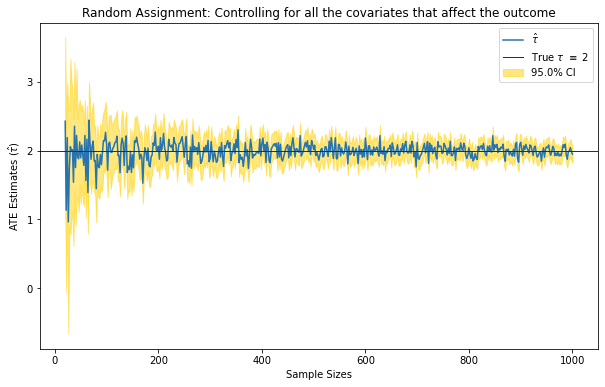

In [11]:
# Plot the ATE estimates and confidence intervals again
# Now I control for X
# You can find the data for CI in '1_3b_CI_RA_with_Covars.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, X_control = True, output = True,
                                                  file_name = '1_3b_CI_RA_with_Covars.csv')

# Plot the results
caption = 'Random Assignment: Controlling for all the covariates that affect the outcome'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

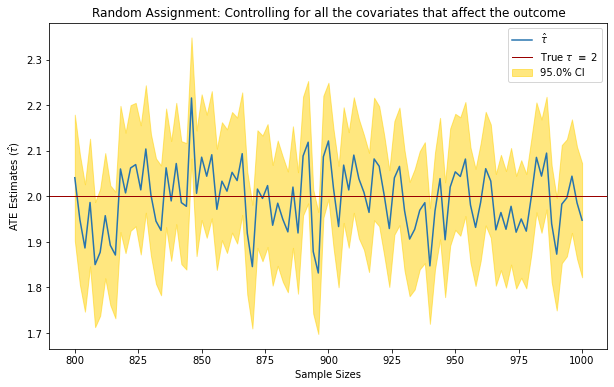

In [12]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

The plots clearly show that the confidence intervals for $\tau$ are much narrower than in part (a) as is expected.

The following shows the results of the Monte Carlo simulations with $\mathbf{X}$ controlled.

In [13]:
# Monte Carlo simulations with X controlled
# You can find the data of tauhats in '1_4b_MC_RA_with_Covars.csv'
fn_monte_carlo(tau, X_control = True, output = True, file_name = '1_4b_MC_RA_with_Covars.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 133.37it/s]

N = 100: bias = 0.000954, RMSE = 0.206098, size = 0.0485
N = 1000: bias = -0.001638, RMSE = 0.064385, size = 0.0530


The results imply that controlling for $\mathbf{X}$ improves the estimator in terms of both bias and RMSE. The size is slightly closer to 5% than in part (a).

Thus, I conclude that controlling for pre-treatment covariates is preferable for estimating ATE under random assignment.

### 1.4 Real-Life Situation Consistent with the DGP

Suppose that we are interested in an effect of a college meal plan on student weight. If the college can randomly assign students to a treatment group (that can use the plan) or a control group (that cannot), we can estimate the ATE of the plan by taking difference in average weights between treatment and control groups.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

But the standard error of the estimator can be pretty large if weights are affected by other pre-treatment variables such as gender, age, parental income and so forth. If these variables are observable, we can include them as covariates so that they would explain some of the variance in student weights and reduce the standard error of the estimator. The DAG illustration of this situation is as follows:

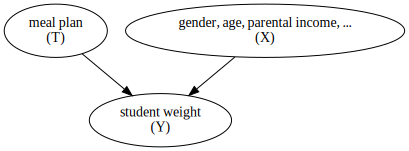

In [14]:
# Create the DAG
g1r = gr.Digraph()
g1r.edge('meal plan \n (T)', 'student weight \n (Y)')
g1r.edge('gender, age, parental income, ... \n (X)', 'student weight \n (Y)')

g1r

## 2. With a Confounder

### 2.1 DGP Simulation

I assume the following DGP in this section:

$$
Y = \alpha + \tau T + \mathbf{X} \beta_1 + \beta_2 C + e,
$$

where

- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect, i.e., $Y_1 - Y_0 = \tau$ for any observations where $Y_1$ and $Y_0$ are potential outcomes,
- $T$ (treatment) is an $N \times 1$ matrix whose element is independent of $\mathbf{X}$ but *not* independent of a confounder $C$; specifically, $T_i, i = 1, \ldots, N$ is assumed to be

$$
T_i = I \left(\frac{\exp(\gamma C_{norm, i} + \tilde{e}_i)}{1 + \exp(\gamma C_{norm, i} + \tilde{e}_i)} > p \equiv 0.5 \right),
$$

where $I (\cdot)$ is the indicator function, $ \gamma \sim U(0,1)$, $C_{norm, i}$ is the $i$-th element of the normalized $C$ (so that it has a mean of zero and a variance of one) and $ \tilde{e}$ is a $N \times 1$ matrix whose element follows *i.i.d.* $N(0, 1)$. Since $\gamma > 0$, $T$ and $C$ should be positively related,

- $\mathbf{X}$ (covariates) is an $N \times 10$ matrix (i.e., there are 10 covariates) whose row follows a multivariate normal distribution that has a within-correlation of 0.5,
- $\beta_1$ (coefficients on covariates) is a $10 \times 1$ matrix whose element follows *i.i.d.* $N(1, 1)$,
- $\beta_2 \sim N(1, 1)$ (coefficient on confounder),
- $C$ (confounder) is an $N \times 1$ matrix whose element follows a normal distribution, and
- $e$ (disturbance) is an $N \times 1$ matrix whose element follows *i.i.d.* $N(0, 1)$.

Since $T$, $Y_0$ and $Y_1$ depend on $C$ now, we cannot assume $Y_0, Y_1 \perp T$. However, as is suggested by the DAG below, we can still assume the independence **after controlling for the confounder** $C$, i.e., $Y_0, Y_1 \perp T | C$.  
  
As in the previous section, I generate one set of variables and plot histograms with $N = 1000$ first.

In [15]:
# Generate data
# You can find the data in '2_1_Confounder.csv'
tau = 2; nobs = 1000

dgp2 = my_DGP(nobs, conf = True)
Y, T, X, C, _, _ = dgp2.generate(tau, output = True, file_name = '2_1_Confounder.csv')

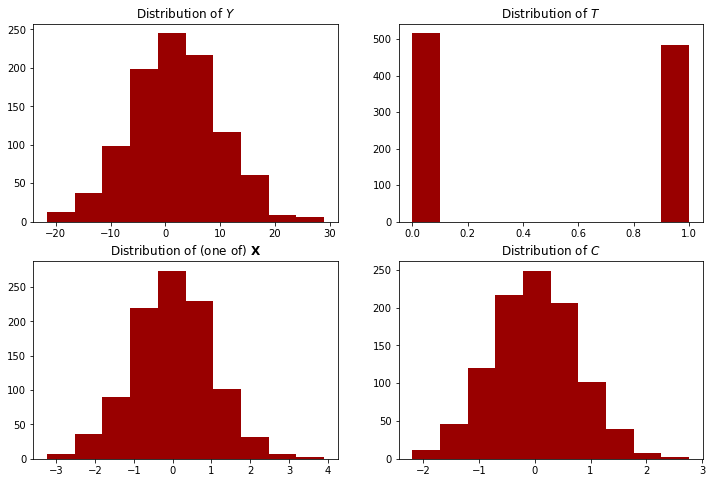

In [16]:
# Plot distributions of data
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

axes[0, 0].hist(Y)
axes[0, 0].set_title('Distribution of $Y$', fontdict = {'fontsize': 12})

axes[0, 1].hist(T)
axes[0, 1].set_title('Distribution of $T$', fontdict = {'fontsize': 12})

axes[1, 0].hist(X[:, 0])
axes[1, 0].set_title('Distribution of (one of) $\mathbf{X}$', fontdict = {'fontsize': 12})

axes[1, 1].hist(C)
axes[1, 1].set_title('Distribution of $C$', fontdict = {'fontsize': 12})

plt.show()

Since $T$ depends on $C$ now, the treatment and control are not perfectly balanced.

As before, I check the correlations between variables by a Monte Carlo simulation.

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 460.10it/s]


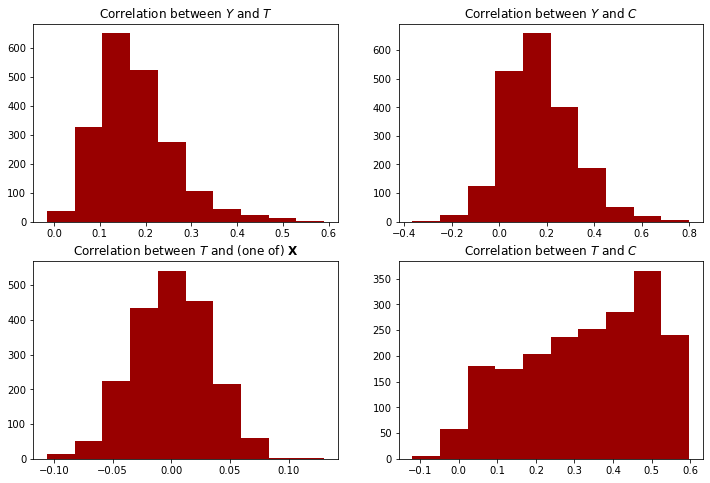

In [17]:
# Plot correlations between variables
# You can find the data of correlations in '2_2_Correlations_Conf.csv'
dgp2.plot_corr(tau)

We can see that $Y$ and $T$ are positively correlated with $C$. Thus, as textbook econometrics suggests, omitting $C$ would cause an upward bias in the estimator for ATE.

### 2.2 DAG Illustration

The DGP is illustrated by the following DAG. It is clear that $C$ is a common cause of treatment $T$ and outcome $Y$ by design of the DGP.

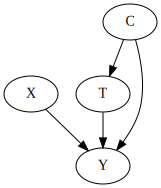

In [18]:
# Create the DAG
g2 = gr.Digraph()
g2.edge('T', 'Y')
g2.edge('X', 'Y')
g2.edge('C', 'T')
g2.edge('C', 'Y')

g2

### 2.3 Monte Carlo Simulation

#### a. Not controlling for the confounder

First, I compute the ATE estimate $\hat{\tau}$ by OLS assuming the following model:

$$
Y = \alpha + \tau T + \mathbf{X} \beta_1 + e.
$$

That is, I do not control for the confounder $C$ while controlling for the covariates $\mathbf{X}$. According to the theory, $\hat{\tau}$ should be biased since I fail to block the backward path $T \leftarrow C \rightarrow Y$ in the DAG.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:00<00:00, 515.60it/s]


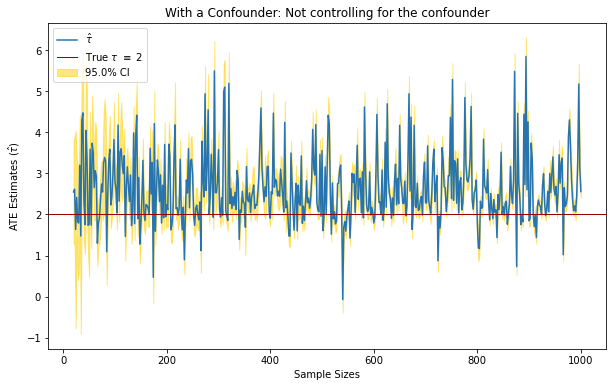

In [19]:
# Plot the ATE estimates and confidence intervals
# I do not control for the confounder
# You can find the data for CI in '2_3a_CI_Conf_without_Conf.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, conf = True, X_control = True, C_control = False,
                                                  output = True, file_name = '2_3a_CI_Conf_without_Conf.csv')

# Plot the results
caption = 'With a Confounder: Not controlling for the confounder'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

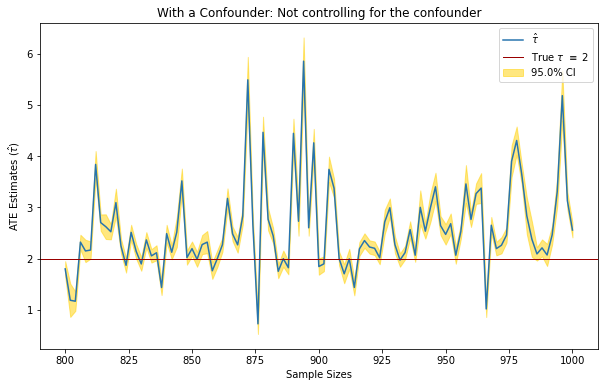

In [20]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

The estimator $\hat{\tau}$ apparently fails to converge to the true value of $\tau \equiv 2$. It suffers from an upward bias, which is consistent with the theory of omitted variable bias.

Now I run Monte Carlo simulations with sample sizes of $N = 100$ and $N = 1000$. 

In [21]:
# Monte Carlo simulations without controlling for C
# You can find the data of tauhats in '2_4a_MC_Conf_without_Conf.csv'
fn_monte_carlo(tau, conf = True, X_control = True, C_control = False,
               output = True, file_name = '2_4a_MC_Conf_without_Conf.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 392.71it/s]

N = 100: bias = 0.631349, RMSE = 1.109052, size = 0.4740
N = 1000: bias = 0.626381, RMSE = 1.029952, size = 0.7805


The results show great bias and RMSE. Both of them fail to improve very much as the sample size increases. The size is far from 5%, so we should say that the estimator makes no sense.

#### b. Controlling for the confounder

Now I control for the confounder $C$ and obtain $\hat{\tau}$ by regressing

$$
Y = \alpha + \tau T + \mathbf{X} \beta_1 + \beta_2 C + e.
$$

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 424.22it/s]


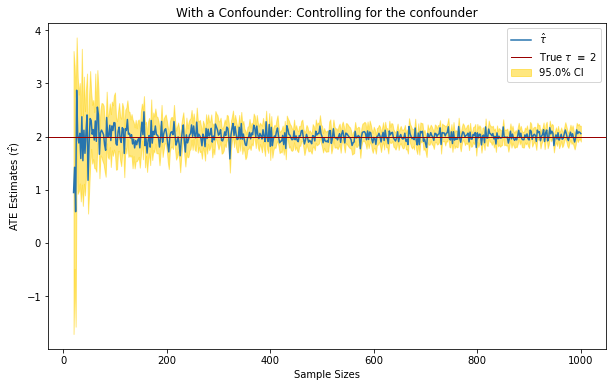

In [22]:
# Plot the ATE estimates and confidence intervals
# Now I control for the confounder
# You can find the data for CI in '2_3b_CI_Conf_with_Conf.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, conf = True, X_control = True, C_control = True,
                                                  output = True, file_name = '2_3b_CI_Conf_with_Conf.csv')

# Plot the results
caption = 'With a Confounder: Controlling for the confounder'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

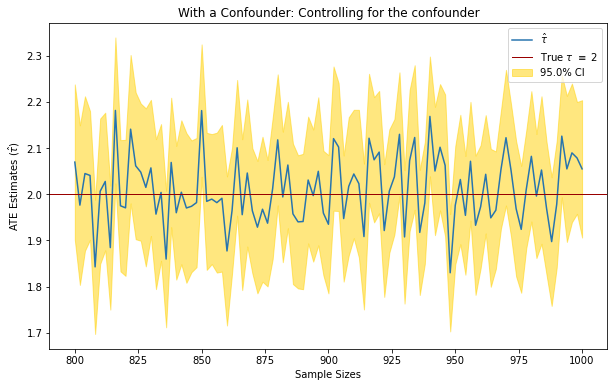

In [23]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

Now we can find a great improvement; $\hat{\tau}$ fluctuates around and converges to $\tau \equiv 2$ as in section 1. It appears that controlling for $C$ allows us to treat $T$ as independent of potential outcomes $Y_0$ and $Y_1$.

The Monte Carlo simulations generate the following results.

In [24]:
# Monte Carlo simulations with C controlled
# You can find the data of tauhats in '2_4b_MC_Conf_with_Conf.csv'
fn_monte_carlo(tau, conf = True, X_control = True, C_control = True,
               output = True, file_name = '2_4b_MC_Conf_with_Conf.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 400.56it/s]

N = 100: bias = -0.000550, RMSE = 0.227644, size = 0.0475
N = 1000: bias = -0.000538, RMSE = 0.069878, size = 0.0470


The bias and the RMSE are much smaller than in part (a). Moreover, the size is close to 5% as it should be theoretically.

Therefore, presumably, I have sort of "proved" that confounders should be controlled when estimating ATE.

### 2.4 Real-Life Situation Consistent with the DGP

Suppose that we are interested in a return to college education, i.e., causal effect of college education on earnings. In this setting, the treatment (going to college) and the outcome (earnings) obviously have confounders such as ability; someone with high ability is likely to go to college and they are likely to earn high earnings **even if they do not go to college**. Therefore, we have to control for ability to estimate the ATE of college education on earnings.

Since ability is likely unobservable, we may not be able to control for ability directly. However, we can still control for its proxy (e.g., IQ) if we have data on a variable in the path between ability and college education. By controlling for the proxy, we can block the backward path from treatment (going to college) to outcome (earnings).

As in section 1, we can also control for covariates that are independent of college education (e.g., age) to reduce the standard error. The following DAG illustrates the situation.

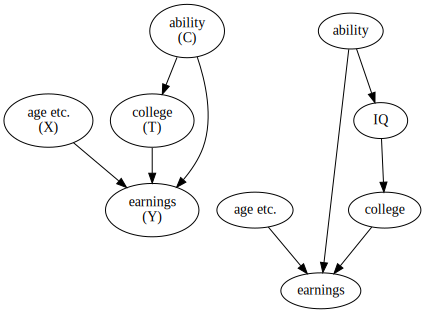

In [25]:
# Create the DAG
g2r = gr.Digraph()
g2r.edge('college \n (T)', 'earnings \n (Y)')
g2r.edge('age etc. \n (X)', 'earnings \n (Y)')
g2r.edge('ability \n (C)', 'college \n (T)')
g2r.edge('ability \n (C)', 'earnings \n (Y)')

g2r.edge('college', 'earnings')
g2r.edge('age etc.', 'earnings')
g2r.edge('ability', 'IQ')
g2r.edge('IQ', 'college')
g2r.edge('ability', 'earnings')

g2r

## 3. With a Selection Bias

### 3.1 DGP Simulation

I assume the following DGP in this section:

$$
Y = \alpha + \frac{\tau}{1 + \delta} T + \frac{\tau}{1 + \delta} S + \mathbf{X} \beta + e,
$$

where

- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect as is shown below,
- $T$ (treatment) is an $N \times 1$ matrix whose element is randomly assigned to 1 with proportion $p \equiv 0.5$ or 0 with $1 - p \equiv 0.5$,
- $S$ (selection bias) is an $N \times 1$ matrix that **depends on** $T$; specifically,

$$
S = \delta T + \varepsilon,
$$

where $\delta \sim U(0,1)$ and $\varepsilon$ is an $N \times 1$ matrix whose element follows *i.i.d.* $N(0,1)$.

- $\mathbf{X}$ (covariates) is an $N \times 10$ matrix (i.e., there are 10 covariates) whose row follows a multivariate normal distribution that has a within-correlation of 0.5,
- $\beta$ (coefficients on covariates) is a $10 \times 1$ matrix whose element follows *i.i.d.* $N(1, 1)$, and
- $e$ (disturbance) is an $N \times 1$ matrix whose element follows *i.i.d.* $N(0, 1)$.

The point is that $T$ affects $Y$ both directly and indirectly via affecting $S$. Substitution yields

$$
Y = \alpha + \frac{\tau}{1 + \delta} T + \frac{\tau}{1 + \delta} (\delta T + \varepsilon) + \mathbf{X} \beta + e = \alpha + \tau T + \mathbf{X} \beta + \frac{\tau}{1 + \delta} \varepsilon + e.
$$

Thus, we can see that the whole effect of treatment (including both direct and indirect ones) is equal to $\tau \equiv 2$. The variable $S$, which we call a selection bias, functions as a variable in the path from the treatment to the outcome.
  
First of all, I generate one set of variables and plot histograms with $N = 1000$ again.

In [26]:
# Generate data
# You can find the data in '3_1_Selection_Bias.csv'
tau = 2; nobs = 1000

dgp3 = my_DGP(nobs, selec = True)
Y, T, X, _, S, _ = dgp3.generate(tau, output = True, file_name = '3_1_Selection_Bias.csv')

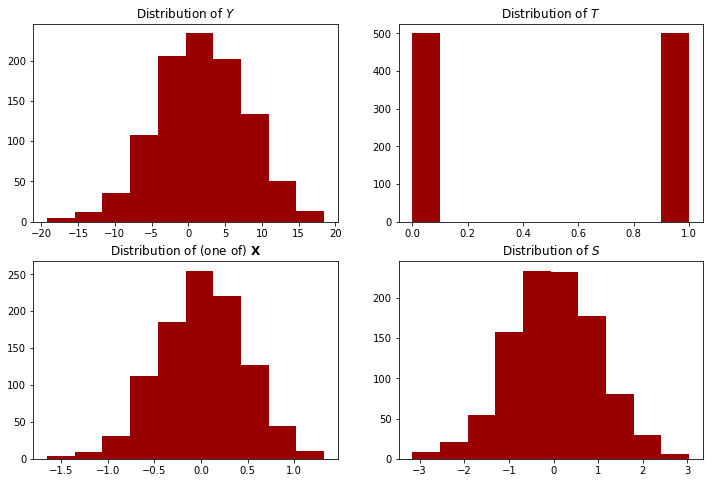

In [27]:
# Plot distributions of data
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

axes[0, 0].hist(Y)
axes[0, 0].set_title('Distribution of $Y$', fontdict = {'fontsize': 12})

axes[0, 1].hist(T)
axes[0, 1].set_title('Distribution of $T$', fontdict = {'fontsize': 12})

axes[1, 0].hist(X[:, 0])
axes[1, 0].set_title('Distribution of (one of) $\mathbf{X}$', fontdict = {'fontsize': 12})

axes[1, 1].hist(S)
axes[1, 1].set_title('Distribution of $S$', fontdict = {'fontsize': 12})

plt.show()

The following histograms of the correlation imply the dependence of $S$ on $T$.

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.09it/s]


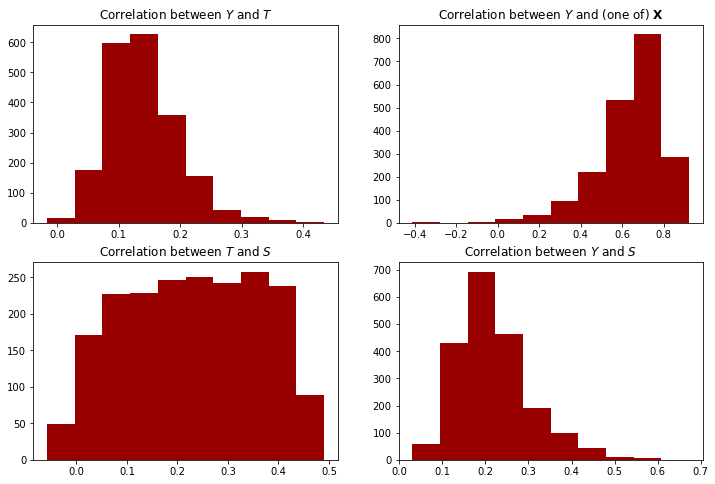

In [28]:
# Plot correlations between variables
# You can find the data of correlations in '3_2_Correlations_Selec.csv'
dgp3.plot_corr(tau)

### 3.2 DAG Illustration

The DGP is illustrated by the following DAG. By design, $S$ is in the path from the treatment to the outcome.

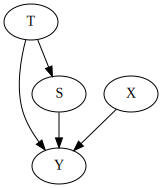

In [29]:
# Create the DAG
g3 = gr.Digraph()
g3.edge('T', 'Y')
g3.edge('T', 'S')
g3.edge('S', 'Y')
g3.edge('X', 'Y')

g3

### 3.3 Monte Carlo Simulation

#### a. Controlling for the selection bias

Here, I estimate the ATE by controlling for the selection bias $S$, i.e., regressing

$$
Y = \alpha + \tau T + \lambda S  + \mathbf{X} \beta + e,
$$

and obtaining the OLS estimate for $\tau$. Since the effect of $T$ on $Y$ is partly blocked by controlling for $S$ (as we can see in the DAG), we can expect that the estimator $\hat{\tau}$ would be biased downwards.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 285.38it/s]


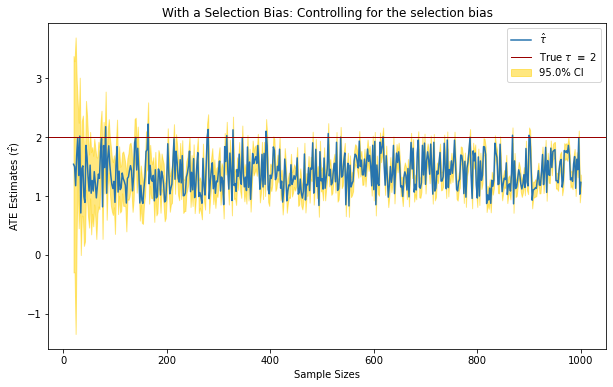

In [30]:
# Plot the ATE estimates and confidence intervals
# I control for the selection bias
# You can find the data for CI in '3_3a_CI_Selec_with_Selec.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, selec = True, X_control = True, S_control = True,
                                                  output = True, file_name = '3_3a_CI_Selec_with_Selec.csv')

# Plot the results
caption = 'With a Selection Bias: Controlling for the selection bias'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

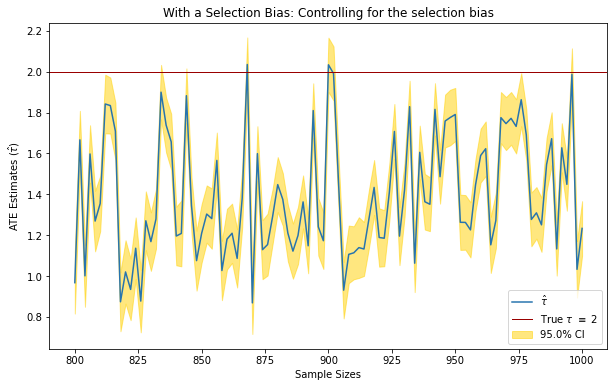

In [31]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

The figures show that the estimator $\hat{\tau}$ suffers from a negative bias, which is consistent with my discussion above.

In [32]:
# Monte Carlo simulations when controlling for S
# You can find the data of tauhats in '3_4a_MC_Selec_with_Selec.csv'
fn_monte_carlo(tau, selec = True, X_control = True, S_control = True,
               output = True, file_name = '3_4a_MC_Selec_with_Selec.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 126.48it/s]

N = 100: bias = -0.624011, RMSE = 0.719361, size = 0.7045
N = 1000: bias = -0.615583, RMSE = 0.678964, size = 0.9330


According to the Monte Carlo simulations, the bias and the RMSE are quite large, and they would not improve very much by increasing the sample size. Further, the size of the *t*-test is far from 5%.

#### b. Not controlling for the selection bias

Now I estimate the ATE by regressing

$$
Y = \alpha + \tau T  + \mathbf{X} \beta + e,
$$

and obtaining the OLS estimate for $\tau$. In other words, I am not controlling for the selection bias $S$ below.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 284.90it/s]


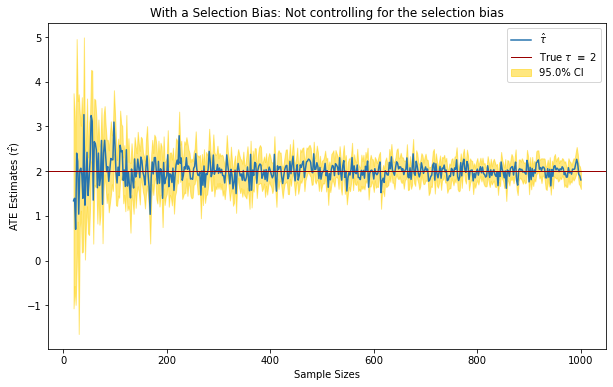

In [33]:
# Plot the ATE estimates and confidence intervals
# Now I do not control for the selection bias
# You can find the data for CI in '3_3b_CI_Selec_without_Selec.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, selec = True, X_control = True, S_control = False,
                                                  output = True, file_name = '3_3b_CI_Selec_without_Selec.csv')

# Plot the results
caption = 'With a Selection Bias: Not controlling for the selection bias'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

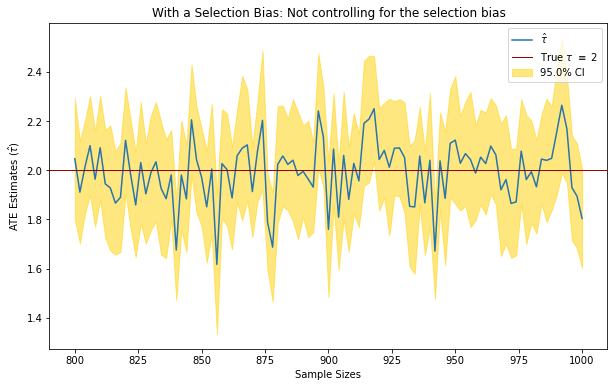

In [34]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

The figures show that $\hat{\tau}$ converges to $\tau \equiv 2$, which implies that the estimator appears to be consistent for the ATE now.

The Monte Carlo simulations lead to the following results.

In [35]:
# Monte Carlo simulations without controlling for S
# You can find the data of tauhats in '3_4b_MC_Selec_without_Selec.csv'
fn_monte_carlo(tau, selec = True, X_control = True, S_control = False,
               output = True, file_name = '3_4b_MC_Selec_without_Selec.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.95it/s]


N = 100: bias = -0.002860, RMSE = 0.362523, size = 0.0485
N = 1000: bias = -0.004332, RMSE = 0.111595, size = 0.0540


Without controlling for $S$, I have obtained the estimator with sufficiently low bias and RMSE. The size is close to the theoretical value 5%.

Comparing the results with those in part (a), we can conclude that we should not controll for the selection bias.

### 3.4 Real-Life Situation Consistent with the DGP

Suppose that we are interested in the effect of iron supplement on earnings in a developing country. If we can randomly assign iron supplement and placebo to participants, we can estimate the ATE by taking the difference in average earnings between treatment group (that have received supplement) and control group (that have received a placebo). We can also control for pre-treatment covariates such as age, gender and so forth, which can reduce the standard error of the estimator.

Further, suppose that the number of hours spent on work is observable. Even if the treatment is randomly assigned, we should **not** control for hours of work because it should be an outcome of the treatment&mdash;participants who have got the supplement could improve their health conditions and thus they would be able to spend more time on work. The hours of work can also affect their earnings positively (especially for those self-employed), which means that hours of work is in the path between the treatment (iron supplement) and the outcome (earnings), The iron supplement can possibly affect earnings through other paths like productivity and wage increases, but controlling for hours of work would still block an important part of its causal effect on earnings, which would result in a downward selection bias.<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

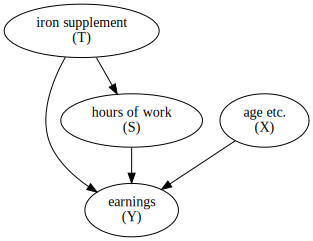

In [36]:
# Create the DAG
g3r = gr.Digraph()
g3r.edge('iron supplement \n (T)', 'earnings \n (Y)')
g3r.edge('iron supplement \n (T)', 'hours of work \n (S)')
g3r.edge('hours of work \n (S)', 'earnings \n (Y)')
g3r.edge('age etc. \n (X)', 'earnings \n (Y)')

g3r

## 4. Outcomes Overrepresented at Zero

### 4.1 DGP Simulation

I assume the following DGP in this section:

$$
Y_i = \begin{cases} \alpha + \tau T_i + u_{1i} \ \mathrm{with} \ \mathrm{proportion} \ p_1 \equiv 0.5 \ \mathrm{(Group \ 1)} \\ 
(\tau + u_{2i})T_i \ \mathrm{with} \ \mathrm{proportion} \ 1 - p_1 \equiv 0.5 \ \mathrm{(Group \ 2)} \end{cases}, \ i = 1, \ldots, N,
$$

where

- $\alpha \equiv 1$ is intercept for Group 1,
- $\tau \equiv 2$ is the true **average** treatment effect, i.e., $E[Y_1 - Y_0] = \tau$ where $Y_1$ and $Y_0$ are potential outcomes,
- $T_i$ (treatment) is randomly assigned to 1 with proportion $p_2 \equiv 0.5$ or 0 with $1 - p_2 \equiv 0.5$, 
- $u_{1i}$ follows a gamma distribution with shape of $\tau \equiv 2$ and scale of $1$, i.e., $u_{1i}$ is always positive and its mean and variance are equal to $\tau \equiv 2$, and
- $u_{2i} \sim U(-\tau/2,\tau/2) \equiv U(-1,1)$.

Note that Group 1 consists of samples whose outcomes are always positive regardless of $T_i$ since $\alpha + \tau T_i + u_{1i} > \alpha + u_{1i} > 0$. On the other hand, a sample in Group 2 generates a positive outcome if and only if $T_i = 1$; for Group 2, $T_i = 0$ implies $Y_i = 0$ and $T_i = 1$ implies $Y_i = \tau + u_{2i} > 0$ by design. This DGP tries to represent the situation shown in [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html), where some of the samples (Rich; Group 1) always participate while the other (Frugal; Group 2) participate if and only if they are treated.

Since the coefficient on $T_i$ for Group 2 depends on $u_{2i}$, the treatment effect is no longer homogeneous. To be exact, $Y_{1i} - Y_{i0} = \tau$ still holds for Group 1, but for Group 2, $Y_{1i} - Y_{i0} = \tau + u_{2i}$ is now a random variable. However, since $\tau + u_{2i} \sim U(\tau \pm \tau/2)$, the expected value of the treatment effect (ATE) is still $\tau \equiv 2$.

Technically, the outcome $Y_i$ is generated $N$ times by

$$
Y_i = G_i (\tau T_i + u_{1i}) + (1 - G_i) [(\tau + u_{2i})T_i], 
$$

where $G_i$ is randomly assigned to 1 with proportion $p_1 \equiv 0.5$ or 0 with $1 - p_1 \equiv 0.5$.

Discarding the samples that have $Y_i = 0$ would cause a bias. That is because it keeps both Groups 1 and 2 in treatment but removes Group 2 in control, and thus treated and controlled samples are no longer comparable. 
  
As all the above, I generate one set of variables and plot histograms with $N = 1000$ first.

In [37]:
# Generate data
# You can find the data in '4_1_Overrepresented_at_Zero.csv'
tau = 2; nobs = 1000

dgp4 = my_DGP(nobs, overrep = True)
Y, T, _, _, _, G = dgp4.generate(tau, output = True, file_name = '4_1_Overrepresented_at_Zero.csv')

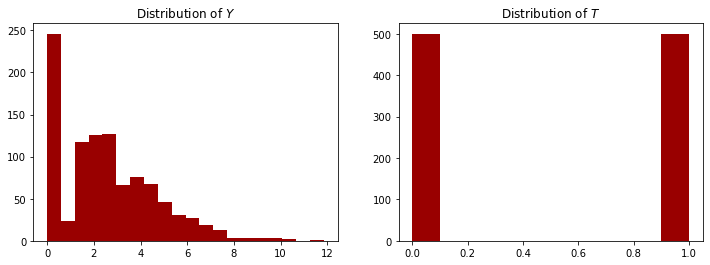

In [38]:
# Plot distributions of data
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

axes[0].hist(Y, bins = 20)
axes[0].set_title('Distribution of $Y$', fontdict = {'fontsize': 12})

axes[1].hist(T)
axes[1].set_title('Distribution of $T$', fontdict = {'fontsize': 12})

plt.show()

We can see that there are a lot of samples whose outcomes are zero (non-participation). Conditional distribution of $Y$ on $T$ and $G$ describes the DGP more clearly.

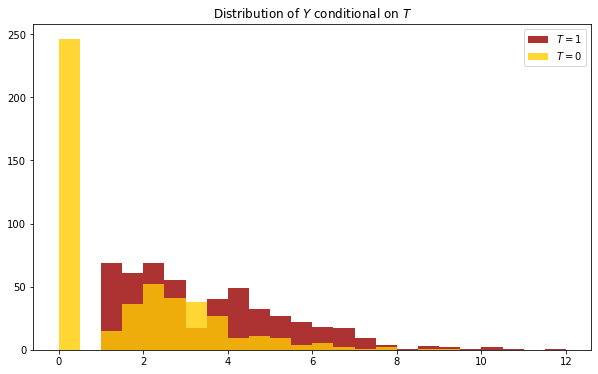

In [39]:
# Plot conditional distribution of Y on T
plt.figure(figsize = (10, 6))
plt.hist(Y[T == 1], label = '$T = 1$', alpha = .8, bins = 24, range = (0, 12))
plt.hist(Y[T == 0], label = '$T = 0$', alpha = .8, bins = 24, range = (0, 12))
plt.title('Distribution of $Y$ conditional on $T$')
plt.legend()
plt.show()

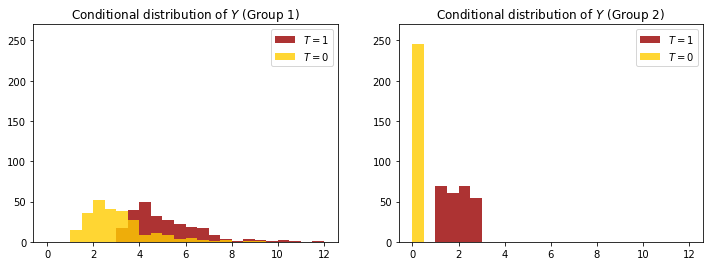

In [40]:
# Plot conditional distribution of Y on T and G
Y_G1 = Y[G == 1]; Y_G2 = Y[G == 0]
T_G1 = T[G == 1]; T_G2 = T[G == 0]

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

axes[0].hist(Y_G1[T_G1 == 1], label = '$T = 1$', alpha = .8, bins = 24, range = (0, 12))
axes[0].hist(Y_G1[T_G1 == 0], label = '$T = 0$', alpha = .8, bins = 24, range = (0, 12))
axes[0].set_ylim((0, 270))
axes[0].legend()
axes[0].set_title('Conditional distribution of $Y$ (Group 1)', fontdict = {'fontsize': 12})

axes[1].hist(Y_G2[T_G2 == 1], label = '$T = 1$', alpha = .8, bins = 24, range = (0, 12))
axes[1].hist(Y_G2[T_G2 == 0], label = '$T = 0$', alpha = .8, bins = 24, range = (0, 12))
axes[1].set_ylim((0, 270))
axes[1].legend()
axes[1].set_title('Conditional distribution of $Y$ (Group 2)', fontdict = {'fontsize': 12})

plt.show()

We can see that all of the samples whose outcomes are zero come from Group 2 and that none of them are treated. Thus, discarding the non-participating samples would distort the distribution and make treatment and control subsamples incomparable.

### 4.2 DAG Illustration

To make the causal relationship clearer, I define a variable for participation:

$$
Z_i \equiv I(Y_i > 0), \ i = 1, \ldots, N.
$$

By design, we can assume that $Z$ is caused by $T$; $T_i = 0$ is a necessary condition for $Z_i = 0$. Since participation implies higher outcome than non-participation by definition, we can also interpret that $Y$ is partly caused by $Z$. $T$ also directly affects $Y$ as in Group 1, where all the samples participate regardless of the treatment status.

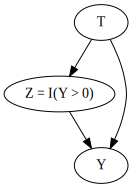

In [41]:
# Create the DAG
g4 = gr.Digraph()
g4.edge('T', 'Z = I(Y > 0)')
g4.edge('Z = I(Y > 0)', 'Y')
g4.edge('T', 'Y')

g4

### 4.3 Monte Carlo Simulation

#### a. Using Conditional-on-Positives (COP) framework

In a "bad" COP framework, we incorrectly try to estimate ATE conditional on positive outcome after treatment, i.e.,

$$
E[Y_1 - Y_0 | Y_1 > 0],
$$

by computing

$$
E[Y | Y > 0, T = 1] - E[Y | Y > 0, T = 0],
$$

which can be estimated by regressing

$$
Y = \alpha + \tau T + \phi Z + e.
$$

Note that controlling for $Z$ is equivalent to discarding non-participating samples. That is, it is the same as regressing $Y = \alpha + \tau T + e$ using only the subsamples that satisfy $Y > 0$.<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3)

However, it does **not** necessarily hold that $E[Y | Y > 0, T = 1] - E[Y | Y > 0, T = 0] = E[Y_1 - Y_0 | Y_1 > 0]$ because

$$
\begin{align*}
E[Y | Y > 0, T = 1] - E[Y | Y > 0, T = 0] &= E[Y_1 | Y_1 > 0, T = 1] - E[Y_0 | Y_0 > 0, T = 0] \\
                                          &= E[Y_1 | Y_1 > 0] - E[Y_0 | Y_0 > 0] \\
                                          &= E[Y_1 - Y_0 | Y_1 > 0] + (E[Y_0 | Y_1 > 0] - E[Y_0 | Y_0 > 0]),
\end{align*}
$$

the second term of which can be considered as a selection bias.

Since $\mathrm{Pr}(Y_1 > 0) = 1$ holds in my DGP, we can see that $E[Y_1 - Y_0 | Y_1 > 0] = E[Y_1 - Y_0] = \tau$. Thus, in my context, the "bad" COP framework tries to estimate the true ATE $\tau$ by regressing $Y = \alpha + \tau T + \phi Z + e,$ but, as we have seen above, the estimator $\hat{\tau}$ should be inconsistent for $\tau$.

As implied by the DAG, this situation can be considered as an example of selection bias. Thus, we can expect that controlling for $Z$ would cause a downward bias in $\hat{\tau}$ by blocking a part of the effect of $T$ on $Y$. Alternatively, since the selection bias is given by $E[Y_0 | Y_1 > 0] - E[Y_0 | Y_0 > 0]$, we can expect that the downward bias should occur because $E[Y_0 | Y_1 > 0]$ (which is an average of $Y_0$ of whole samples) should be smaller than $E[Y_0 | Y_0 > 0]$ (which is an average of $Y_0$ of Group 1 only).

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 263.14it/s]


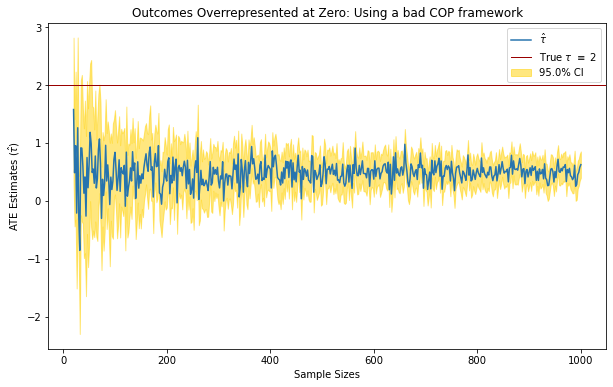

In [42]:
# Plot the ATE estimates and confidence intervals
# I use the bad COP framework, i.e., control for the participation
# You can find the data for CI in '4_2a_CI_COP.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, overrep = True, COP = True,
                                                  output = True, file_name = '4_2a_CI_COP.csv')

# Plot the results
caption = 'Outcomes Overrepresented at Zero: Using a bad COP framework'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

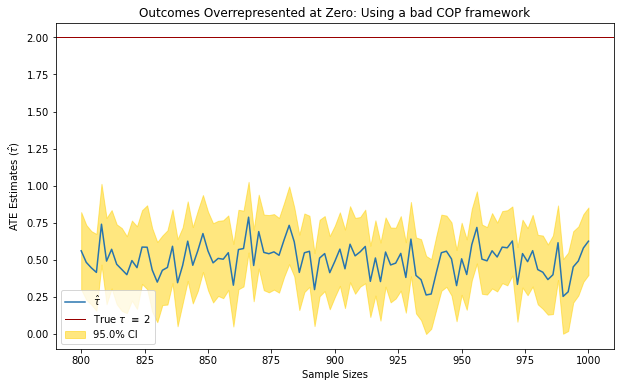

In [43]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

As expected, $\hat{\tau}$ appears to converge to a lower value than $\tau \equiv 2$, which implies that there is a downward bias.

In [44]:
# Monte Carlo simulations based on a bad COP
# You can find the data of tauhats in '4_3a_MC_COP.csv'
fn_monte_carlo(tau, overrep = True, COP = True, output = True, file_name = '4_3a_MC_COP.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.80it/s]

N = 100: bias = -1.492062, RMSE = 1.533321, size = 0.9790
N = 1000: bias = -1.502493, RMSE = 1.506494, size = 1.0000


Monte Carlo simulations generate huge bias and RMSE. The size is almost 100%, which does not make sense at all.

#### b. Using the conventional method

Now I estimate the ATE using the conventional method, i.e., by regressing

$$
Y = \alpha + \tau T + e,
$$

using all the samples. As we have seen in section 3, not including the selection bias (i.e., the participation $Z$ in this section) would realize an unbiased estimate for ATE $\tau$.

100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:02<00:00, 222.22it/s]


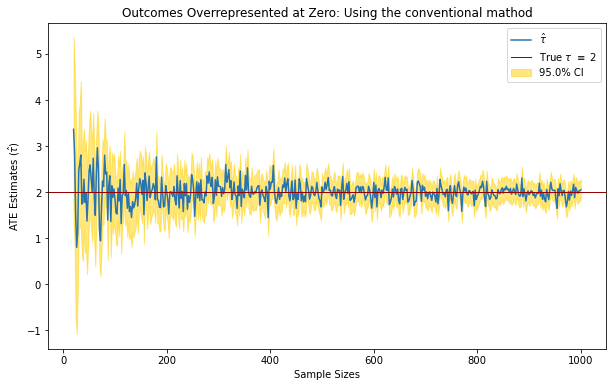

In [45]:
# Plot the ATE estimates and confidence intervals
# Now I use the conventional framework, i.e., do not control for the participation
# You can find the data for CI in '4_2b_CI_Conventional.csv'
n_values, tauhats, sehats, lb, ub = fn_experiment(tau, overrep = True, COP = False,
                                                  output = True, file_name = '4_2b_CI_Conventional.csv')

# Plot the results
caption = 'Outcomes Overrepresented at Zero: Using the conventional mathod'; n_lim = [0, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

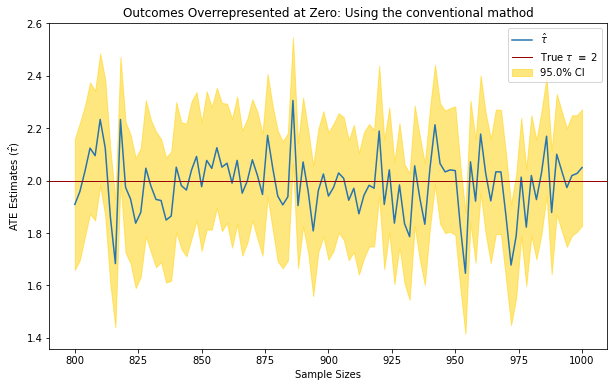

In [46]:
# Zoom in
n_lim = [800, 1000]
fn_plot_with_ci(tau, n_values, tauhats, lb, ub, caption, n_lim)

Now the estimator $\hat{\tau}$ appears to converge to the true value of $\tau \equiv 2$.

In [47]:
# Monte Carlo simulations based on the conventional method
# You can find the data of tauhats in '4_3b_MC_Conventional.csv'
fn_monte_carlo(tau, overrep = True, COP = False, output = True, file_name = '4_3b_MC_Conventional.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.39it/s]

N = 100: bias = -0.008967, RMSE = 0.373628, size = 0.0535
N = 1000: bias = -0.001538, RMSE = 0.112941, size = 0.0460


Both bias and RMSE are quite small and get even smaller as sample size increases. The size is close to the theoretical value 5%.

Overall, I conclude that the conventional method is preferable over the "bad" COP framework.

### 4.4 Real-Life Situation Consistent with the DGP

Suppose that we are interested in an effect of a free-care health insurance plan on medical expenditure. The free-care users would presumably increase their medical expenditures because they do not have to pay the costs. If we can randomly assign participants to the plan, we can estimate the ATE of the plan by taking difference in average expenditures between the treated and the controlled (conventional framework).

Since expenditures are non-negative and some of them can be zero, researchers might be interested in the causal effect of $E[Y_1 - Y_0 | Y_1 > 0]$. However, controlling for $Y > 0$ (i.e., positive expenditure) would cause a selection bias $E[Y_0 | Y_1 > 0] - E[Y_0 | Y_0 > 0]$ as we have seen above. If the population with $Y_1 > 0$ includes low-cost users that would not pay anything without the plan, which are not included in the population with $Y_0 > 0$, then $E[Y_0 | Y_1 > 0]$ can be smaller than $E[Y_0 | Y_0 > 0]$, which can cause a downward bias. Thus, controlling for positive expenditure (COP framework) is not a good idea.

The following DAG shows it graphically.

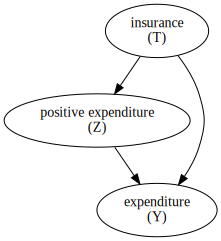

In [48]:
# Create the DAG
g4r = gr.Digraph()
g4r.edge('insurance \n (T)', 'positive expenditure \n (Z)')
g4r.edge('positive expenditure \n (Z)', 'expenditure \n (Y)')
g4r.edge('insurance \n (T)', 'expenditure \n (Y)')

g4r

Footnote:

<a name="cite_note-1"></a>1. [^](#cite_ref-1) What we can estimate is an intention-to-treat effect if there exists non-compliance.

<a name="cite_note-2"></a>2. [^](#cite_ref-2) If the outcome of interest is hourly earnings rather than total earnings, the hours of work would obviously provide useful information.

<a name="cite_note-3"></a>3. [^](#cite_ref-3) Technically, the degrees of freedom would be different across models. I have used $Y = \alpha + \tau T + \phi Z + e$ in this assignment to make it consistent with section 3.